In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import stopwords


[nltk_data] Downloading package wordnet to C:\Users\PC-
[nltk_data]     ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from matplotlib import style,rcParams
style.use('seaborn-white')
rcParams['figure.figsize'] = 10,5
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [4]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from scikitplot.metrics import plot_confusion_matrix

In [5]:
df_train = pd.read_csv("train.txt",delimiter=';',names=['text','label'])
df_val = pd.read_csv("val.txt",delimiter=';',names=['text','label'])

In [6]:
df = pd.concat([df_train,df_val])

In [7]:
print("Shape of the DataFrame:",df.shape)

Shape of the DataFrame: (18000, 2)


In [8]:
df.reset_index(inplace=True,drop=True)

In [9]:
df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


<AxesSubplot:xlabel='label', ylabel='count'>

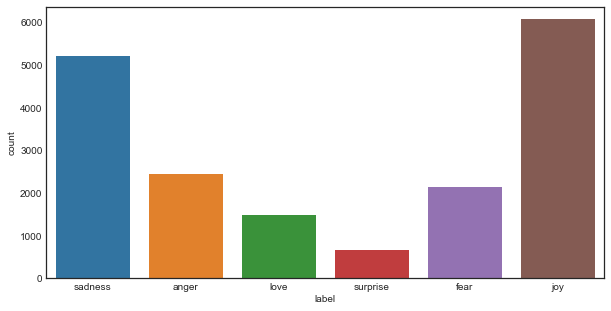

In [10]:
sns.countplot(df.label)

In [11]:
def custom_encoder(df):
    df.replace(to_replace ="surprise", value =1, inplace=True)
    df.replace(to_replace ="love", value =1, inplace=True)
    df.replace(to_replace ="joy", value =1, inplace=True)
    df.replace(to_replace ="fear", value =0, inplace=True)
    df.replace(to_replace ="anger", value =0, inplace=True)
    df.replace(to_replace ="sadness", value =0, inplace=True)

In [12]:
custom_encoder(df['label'])

<AxesSubplot:xlabel='label', ylabel='count'>

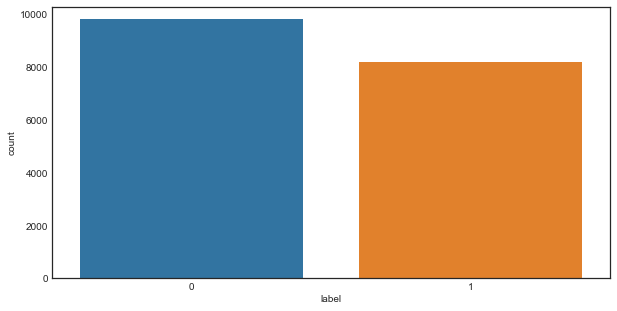

In [13]:
sns.countplot(df.label)

In [14]:
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,1
4,i am feeling grouchy,0


In [15]:
lm = WordNetLemmatizer()

In [16]:
def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

In [17]:
corpus = text_transformation(df['text'])

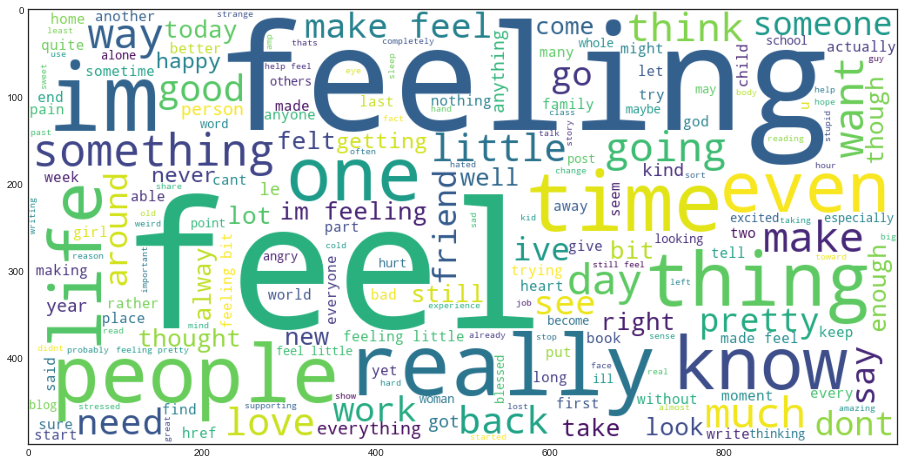

In [18]:
rcParams['figure.figsize'] = 20,8
word_cloud = ""
for row in corpus:
    for word in row:
        word_cloud+=" ".join(word)

wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
cv = CountVectorizer(ngram_range=(1,2))
traindata = cv.fit_transform(corpus)

In [21]:
X = traindata
y = df.label

In [22]:
parameters = {'max_features': ('auto','sqrt'),
             'n_estimators': [500, 1000],
             'max_depth': [10, None],
             'min_samples_split': [5],
             'min_samples_leaf': [1],
             'bootstrap': [True]}

In [ ]:
grid_search = GridSearchCV(RandomForestClassifier(),parameters,cv=5,return_train_score=True,n_jobs=-1)
grid_search.fit(X,y)
grid_search.best_params_

In [ ]:
for i in range(6):
    print('Parameters: ',grid_search.cv_results_['params'][i])
    print('Mean Test Score: ',grid_search.cv_results_['mean_test_score'][i])
    print('Rank: ',grid_search.cv_results_['rank_test_score'][i])

In [ ]:
rfc = RandomForestClassifier(max_features=grid_search.best_params_['max_features'],
                                      max_depth=grid_search.best_params_['max_depth'],
                                      n_estimators=grid_search.best_params_['n_estimators'],
                                      min_samples_split=grid_search.best_params_['min_samples_split'],
                                      min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
                                      bootstrap=grid_search.best_params_['bootstrap'])

In [ ]:
rfc.fit(X,y)

In [ ]:
test_df = pd.read_csv('test.txt',delimiter=';',names=['text','label'])

In [ ]:
X_test,y_test = test_df.text,test_df.label
#encode the labels into two classes , 0 and 1
test_df = custom_encoder(y_test)
#pre-processing of text
test_corpus = text_transformation(X_test)
#convert text data into vectors
testdata = cv.transform(test_corpus)
#predict the target
predictions = rfc.predict(testdata)

In [ ]:
rcParams['figure.figsize'] = 10,5
plot_confusion_matrix(y_test,predictions)
acc_score = accuracy_score(y_test,predictions)
pre_score = precision_score(y_test,predictions)
rec_score = recall_score(y_test,predictions)
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print('-------------------------------------------------------------------')
cr = classification_report(y_test,predictions)
print(cr)

In [ ]:
predictions_probability = rfc.predict_proba(testdata)

In [ ]:
fpr,tpr,thresholds = roc_curve(y_test,predictions_probability[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
def expression_check(prediction_input):
    if prediction_input == 0:
        print("Input statement has Negative Sentiment.")
    elif prediction_input == 1:
        print("Input statement has Positive Sentiment.")
    else:
        print("Invalid Statement.")

In [ ]:
def sentiment_predictor(input):
    input = text_transformation(input)
    transformed_input = cv.transform(input)
    prediction = rfc.predict(transformed_input)
    expression_check(prediction)

In [ ]:
input1 = ["Sometimes I just want to punch someone in the face."]
input2 = ["I bought a new phone and it's so good."]
sentiment_predictor(input1)
sentiment_predictor(input2)